# Charts and Graphs for Data Analysis

The script `pool_process.py` runs on 7 different CPU cores, to spits out the text into `./output/analalyzed_corpus.json`. This script creates text file that needs a bit of massaging to create a python readable dictionary. Part of the goal of this script is to make a pandas dataframe. 

In [1]:
# thanks to @ninjaaron for help pulling this script section together 
from collections import namedtuple
import json

encode = json.JSONEncoder(ensure_ascii=False).encode

#Book = namedtuple("Book", "ht_id, top_topic, best_match, most_common_topic")
Book = namedtuple("Book", ["ht_id", "year", "subjects", "top_topic", "best_match", "most_common_topic"])
Topic = namedtuple("Topic", "top_num, perc")
BestMatch = namedtuple("BestMatch", "page, top_num, perc")

with open("analyzed_corpus3.json") as fh:
    books = eval(fh.read())



The Following code takes the hierarchical dataframe, and flatens it out to be easily imported into a pandas dataframe.  

In [2]:
analyzed_list = []
for book in books.values():
    out_dict = {}
    try:
        dct = book._asdict()
    except AttributeError:
        pass
    out_dict['ht_id'] = dct['ht_id']
    out_dict['year'] = dct['year']
    out_dict['subjects'] = dct['subjects']
    for key, value in dct.items():
        try:
            for inner_key, inner_value in value._asdict().items():
                out_dict[key+'_'+inner_key] = inner_value    
            # dct[key] = value._asdict()
        except AttributeError:
            pass
    analyzed_list.append(out_dict)

In [3]:
# This is what each line looks like after we open in it. 
analyzed_list[0]

{'ht_id': 'mdp.39015019393407',
 'year': '1974',
 'subjects': 'Political science History | Conservatism History. | Democracy History. | Liberalism History.',
 'top_topic_top_num': 5,
 'top_topic_perc': 0.3887231835384959,
 'best_match_page': 162,
 'best_match_top_num': 5,
 'best_match_perc': 0.8628564,
 'most_common_topic_top_num': 5,
 'most_common_topic_perc': 97}

Next we create the dataframe we will use, and reorder the columns. 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.DataFrame(analyzed_list)
columns = [
     'ht_id',
     'year', 
     'subjects',
     'top_topic_top_num',
     'top_topic_perc',
     'best_match_page',
     'best_match_top_num',
     'best_match_perc',
     'most_common_topic_top_num',
     'most_common_topic_perc',
]
df = df[columns]

# Supplementing The Dataframe with Data about each record

The year publication date used for this, can easily be retrieved from the volume output. The year date was pulled in through the HathiTrust FeatureReader. The entire Marc record is available through the feature reader. Unfortunately, I forgot to include the title information in the `pool_process.py`. 

But we do need to add our selected Topic titles.


In [6]:
topic_num2name = {
    0: 'Black Experience',
    1: 'Context of Migrant Experience',
    3: 'Communal Experience',
    5: 'Social, Political, Economic Migrations',
    6: 'Immigration and American Christianity',
    11: 'Religion and Culture',
}

In [7]:
import sqlite3

In [8]:
# Unfortunately this data is not available in the github repo, but won't be necessary if you include
# The proper additions in the `pool_process.py` script
conn = sqlite3.connect('../data/politheo.db')
cur = conn.cursor()

In [9]:
'''
def get_year(row):
    ht_id = row['ht_id']
    query = 'SELECT date FROM hathitrust_rec WHERE htitem_id = ?'
    cur.execute(query, (ht_id, ))
    year = cur.fetchone()
    year = int(year[0].split('-')[0])
    return year
    
    
df['date'] = df.apply(get_year, axis=1)
df.columns
''' 

"\ndef get_year(row):\n    ht_id = row['ht_id']\n    query = 'SELECT date FROM hathitrust_rec WHERE htitem_id = ?'\n    cur.execute(query, (ht_id, ))\n    year = cur.fetchone()\n    year = int(year[0].split('-')[0])\n    return year\n    \n    \ndf['date'] = df.apply(get_year, axis=1)\ndf.columns\n"

Sorting the date by the decade. 

In [10]:
df['decade'] = df.apply(lambda x: (int(x['year'])//10)*10, axis=1)

## Number of Pages Dominated by a Particular Topic 

This chart shows how many pages are dominated by a particular topic over time. This is grouped by decade.  

In [11]:
most_common_df = df.groupby(['most_common_topic_top_num', 'decade'])['most_common_topic_perc'].sum().unstack('most_common_topic_top_num')

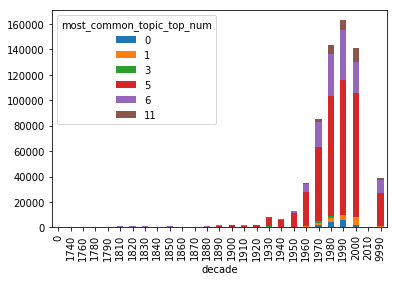

In [12]:
most_common_df.plot(kind='bar', stacked=True)

This final part saves the script in a png file. 

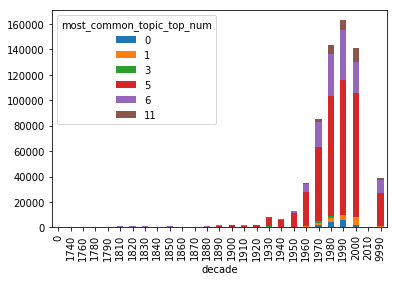

In [13]:
most_common_plot = most_common_df.plot(kind='bar', stacked=True).get_figure()
most_common_plot.savefig('./output/most_common_plot.png')

## Top Topic Averages 

The top_topic column is an average rating of how well the topics match a particular volume. This chart takes an average of those averages by decade to see if there are any decades which have particular highlights on which books where were. 

In [14]:
top_topic_df = df.groupby(['top_topic_top_num', 'decade'])['top_topic_perc'].mean().unstack('top_topic_top_num')

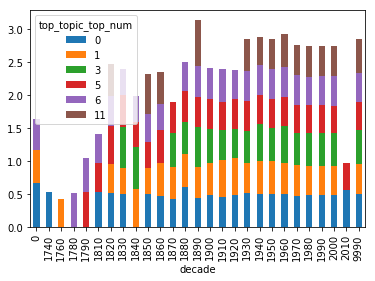

In [15]:
top_topic_df.plot(kind='bar', stacked=True)

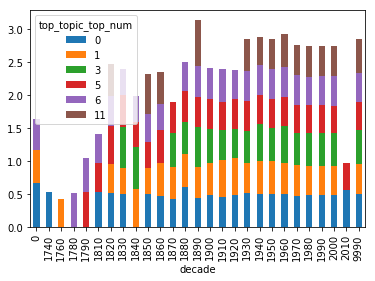

In [16]:
# This code saves the chart to a graph. 
top_topic_fig = top_topic_df.plot(kind='bar', stacked=True).get_figure()
top_topic_fig.savefig('./output/top_topic_fig.png')

## Best Match 

I tried a couple of approaches to find the best match. The Best match was calculated by finding the topic that best matched the model, and showing which page in the volume that came from. I thought it might be interesting to see which decade had the best, best match. But it turns out that this wasn't a particularly helpful measure. 

In [17]:
best_match_df = df.groupby(['best_match_top_num', 'decade'])['best_match_perc'].max().unstack('best_match_top_num')

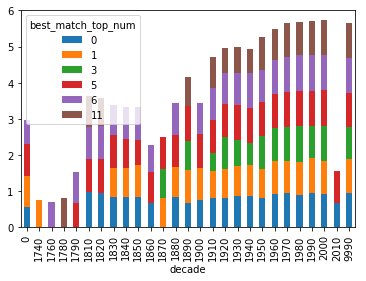

In [18]:
best_match_df.plot(kind='bar', stacked=True)

Digging into the actual dataframe that produces the chart is a little more interesting. For the decades that only have one or two matches, it is because there are only one or two books that represent that decade. This did lead to the realization that we need a more percise way of looking at the best match data. 

In [19]:
best_match_df

best_match_top_num,0,1,3,5,6,11
decade,,,,,,
0,0.555335,0.862857,NaN,0.880000,0.680000,NaN
1740,NaN,0.759997,NaN,NaN,NaN,NaN
1760,NaN,NaN,NaN,NaN,0.696676,NaN
1780,NaN,NaN,NaN,NaN,NaN,0.808000
1790,NaN,NaN,NaN,0.679999,0.862856,NaN
1810,0.985231,NaN,NaN,0.906667,0.893333,0.839999
1820,0.951826,NaN,NaN,0.931428,0.931428,0.755001
1830,0.840000,0.807999,NaN,0.893333,0.833935,NaN
1840,0.842599,0.807999,NaN,0.804002,0.862857,NaN


### Best Match Spread Sheet 

I thought it would be worth digging into the data to see which books had high matches. As well as a high representative of that topic across the book. The first script creates a data frame where the most common topic and the best match topic are the same. This will help promote the aboutness of a particular work will be about the topic we are interseted in. 

In [20]:
# The Top Five Pages for Each topic, Title, and Year

# df.groupby('best_match_top_num')['best_match_top_num', 'ht_id', 'best_match_page', 'best_match_perc'].head()
bmatch_df = df[df['most_common_topic_top_num'] == df['best_match_top_num']].sort_values(by=['best_match_top_num', 'best_match_perc'], ascending=False)

In [21]:
# The colomuns of the topic are still all the ones we have
bmatch_df.columns

Index(['ht_id', 'year', 'subjects', 'top_topic_top_num', 'top_topic_perc',
       'best_match_page', 'best_match_top_num', 'best_match_perc',
       'most_common_topic_top_num', 'most_common_topic_perc', 'decade'],
      dtype='object')

These two functions can add additional information from the Hathi Trust database created in the Political Theological project. The title could also be added to the dataframes when the entire corpus is run over the data. 

In [22]:
def find_title(row):
    query = 'SELECT title FROM hathitrust_rec WHERE htitem_id = ?'
    cur.execute(query, (row['ht_id'], ))
    title = cur.fetchone()
    return title[0]

'''

def find_subjects(row):
    query = 'SELECT subject_heading FROM htitem2subjhead WHERE htitem_id = ?'
    cur.execute(query, (row['ht_id'], ))
    subjects = cur.fetchall()
    return ' | '.join([x[0] for x in subjects])
'''

"\n\ndef find_subjects(row):\n    query = 'SELECT subject_heading FROM htitem2subjhead WHERE htitem_id = ?'\n    cur.execute(query, (row['ht_id'], ))\n    subjects = cur.fetchall()\n    return ' | '.join([x[0] for x in subjects])\n"

In [23]:
# apply find_title to the dataframe
bmatch_df['title'] = bmatch_df.apply(find_title, axis=1)

In [24]:
# add the topic name to the dataframe
bmatch_df['top_nam'] = bmatch_df.apply(lambda x: topic_num2name[x['best_match_top_num']], axis=1)

In [25]:
# add the subjects to the dataframe. 
# Subjects likewise are available in the hathitrust record reader
# bmatch_df['subjects'] = bmatch_df.apply(find_subjects, axis=1)

In [26]:
# This cell reorders the columns in a more intuitive order
bmatch_df = bmatch_df[
    ['top_nam',
     'best_match_top_num',
     'ht_id', 
     'title',
     'year',
     'subjects',
     'best_match_page',                     
     'best_match_perc',      
     'most_common_topic_top_num', 
     'most_common_topic_perc'
    ]
].reset_index(drop=True)

The following DataFrame shows the top five records for each of the Topic Models

In [27]:
bmatch_df.groupby('best_match_top_num').head(5)

,top_nam,best_match_top_num,ht_id,title,year,subjects,best_match_page,best_match_perc,most_common_topic_top_num,most_common_topic_perc
0,Religion and Culture,11,mdp.39015063320546,New approaches to the study of religion / edit...,9999,Religion Study and teaching History 20th century.,501,0.953334,11,166
1,Religion and Culture,11,mdp.39015063320546,New approaches to the study of religion / edit...,9999,Religion Study and teaching History 20th century.,501,0.953334,11,166
2,Religion and Culture,11,uva.x006167926,Communio viatorum. v.43-44 2001-2002,2002,Theology Periodicals.,563,0.949474,11,64
3,Religion and Culture,11,inu.30000004992420,Synthesis philosophica.,9999,Philosophy Periodicals.,13,0.926154,11,84
4,Religion and Culture,11,uva.x006090923,Post-theism : reframing the Judeo-Christian tr...,2000,Theism. | Christianity and other religions Jud...,102,0.926154,11,122
302,Immigration and American Christianity,6,uva.x000685789,Nairobi to Vancouver : 1975-1983 : Report of t...,1983,Ecumenical movement Congresses.,267,0.979575,6,96
303,Immigration and American Christianity,6,ien.35556030059356,Catholic Eastern Churches : heritage and ident...,1994,Catholic Church Malabar rite. | Catholic Churc...,28,0.974737,6,173
304,Immigration and American Christianity,6,mdp.39015021629806,The Mennonite encyclopedia : a comprehensive r...,9999,Anabaptists Dictionaries. | Mennonites Diction...,836,0.972571,6,514
305,Immigration and American Christianity,6,mdp.39015021629806,The Mennonite encyclopedia : a comprehensive r...,9999,Anabaptists Dictionaries. | Mennonites Diction...,836,0.972571,6,514
306,Immigration and American Christianity,6,uva.x030152181,"Grant$ for religion, religious welfare, &amp; ...",2007,Endowments United States Directories. | Religi...,232,0.972000,6,174


In [28]:
# This cell saves the dataframe to a 
bmatch_df.to_excel('./output/best_match.xlsx', index=False)